# The Cars Dataset
Here we'll use the classic Cars dataset to illustrate different ways Gumbi can be used.

In [1]:
import gumbi as gmb
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use(gmb.style.breve)

Read in some data and store it as a Gumbi `DataSet`:

In [2]:
cars = sns.load_dataset('mpg').dropna().astype({'weight':float, 'model_year':float})

ds = gmb.DataSet(cars,
                 outputs=['mpg', 'acceleration'],
                 log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'])

Create a Gumbi `GP` object:

In [3]:
gp = gmb.GP(ds)

Now we're ready to fit, predict, and plot against various dimensions in our datset.

## Simple regression

In [4]:
gp.fit(outputs=['mpg'], continuous_dims=['horsepower']);

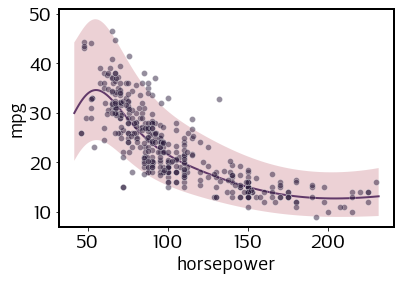

In [5]:
X = gp.prepare_grid()
y = gp.predict_grid();

pp = gmb.ParrayPlotter(X, y)
pp.plot()
sns.scatterplot(data=cars, x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.5);

Note that, despite the error bands appearing wider at lower values of *horsepower*, this actually is a homoskedastic model; i.e., predicted noise does not depend on the input value. However, because we declared *mpg* among the `log_vars` when we defined our `DataSet`, the model is homoskedastic in *log space*. Let's plot `log(mpg)` to illustrate this:

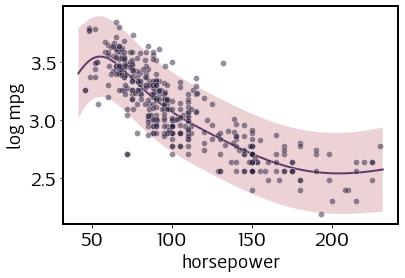

In [6]:
pp.y_scale = 'transformed'
pp.y_tick_scale = 'transformed'
pp.update()
pp.plot()

sns.scatterplot(data=cars.assign(mpg=np.log(cars.mpg)), x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.5);

We declared `horsepower` to be a *log_var* as well. Let's view both `mpg` and `horsepower` in log-space, but retain the natural-space tick labels for easier interpretation.

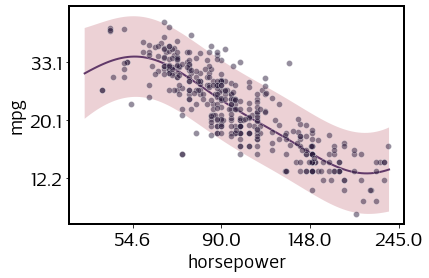

In [7]:
pp.y_tick_scale = 'natural'
pp.x_scale = 'transformed'
pp.update()
pp.plot()

sns.scatterplot(data=cars.assign(mpg=np.log(cars.mpg), horsepower=np.log(cars.horsepower)), x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.5);

## Independent regression for each class in a category

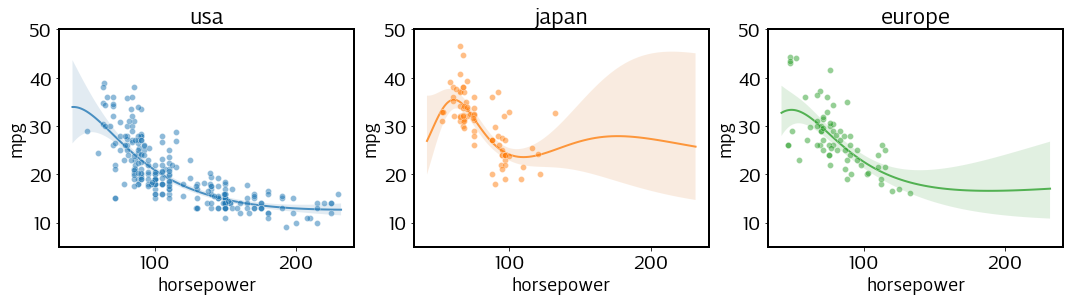

In [8]:
axs = plt.subplots(1,3, figsize=(18, 4))[1]
for i, (ax, origin) in enumerate(zip(axs, cars.origin.unique())):
    gp.fit(outputs=['mpg'], categorical_dims=['origin'], categorical_levels={'origin': origin}, continuous_dims=['horsepower']);
    X = gp.prepare_grid()
    y = gp.predict_grid(with_noise=False)

    gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette(f'C{i}'))
    
    sns.scatterplot(data=cars[cars.origin==origin], x='horsepower', y='mpg', color=f'C{i}', alpha=0.5, ax=ax);
    ax.set_title(origin)
    ax.set_ylim([5, 50])

## Correlated multi-input regression accross different classes in a category

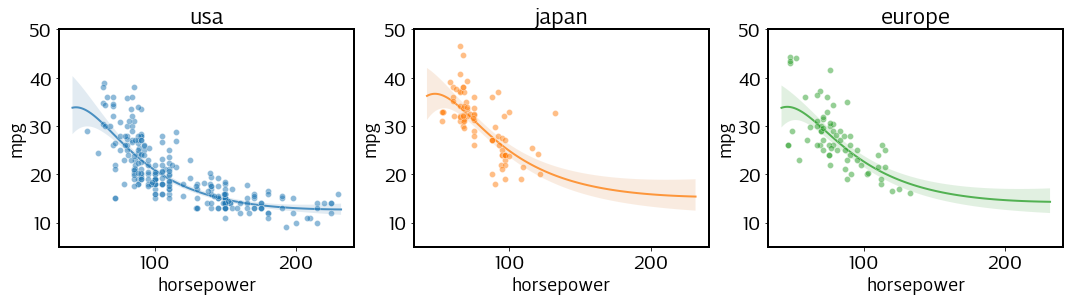

In [9]:
gp.fit(outputs=['mpg'], categorical_dims=['origin'], continuous_dims=['horsepower']);

X = gp.prepare_grid()
axs = plt.subplots(1,3, figsize=(18, 4))[1]
for i, (ax, origin) in enumerate(zip(axs, cars.origin.unique())):
    y = gp.predict_grid(categorical_levels={'origin': origin}, with_noise=False)

    gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette(f'C{i}'))
    
    sns.scatterplot(data=cars[cars.origin==origin], x='horsepower', y='mpg', color=f'C{i}', alpha=0.5, ax=ax);
    ax.set_title(origin)
    ax.set_ylim([5, 50])

## Multi-output regression

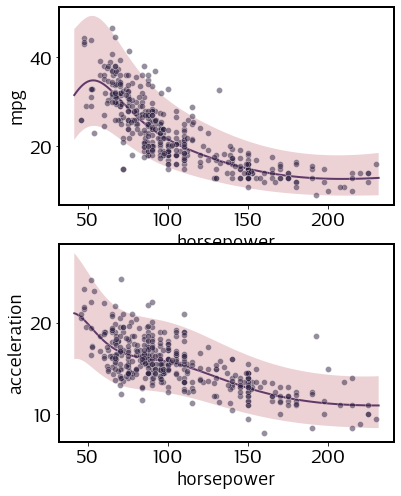

In [10]:
gp.fit(outputs=['mpg', 'acceleration'], continuous_dims=['horsepower']);

X = gp.prepare_grid()
Y = gp.predict_grid()

axs = plt.subplots(2,1, figsize=(6, 8))[1]
for ax, output in zip(axs, gp.outputs):
    y = Y.get(output)

    gmb.ParrayPlotter(X, y).plot(ax=ax)

    sns.scatterplot(data=cars, x='horsepower', y=output, color=sns.cubehelix_palette()[-1], alpha=0.5, ax=ax);

### Correlated multivariate sampling from joint predictions

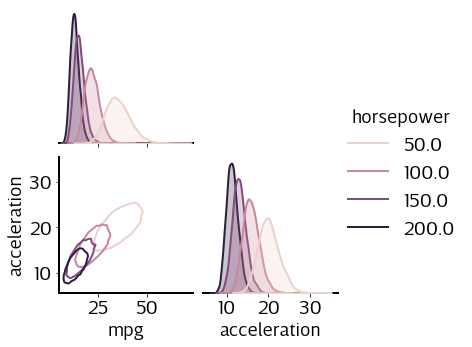

In [11]:
X = gp.parray(horsepower=[50, 100, 150, 200])
gp.predict_points(X)
y = gp.predictions

samples_df = pd.concat(
    [pd.DataFrame(point.dist.rvs(10000, random_state=j).as_dict()).assign(horsepower=hp.values()) for j, (point, hp) in enumerate(zip(y, X))],
    ignore_index=True)

sns.pairplot(samples_df, hue='horsepower', kind='kde', corner=True, plot_kws={'levels': 1});

## Multi-input multi-output regression

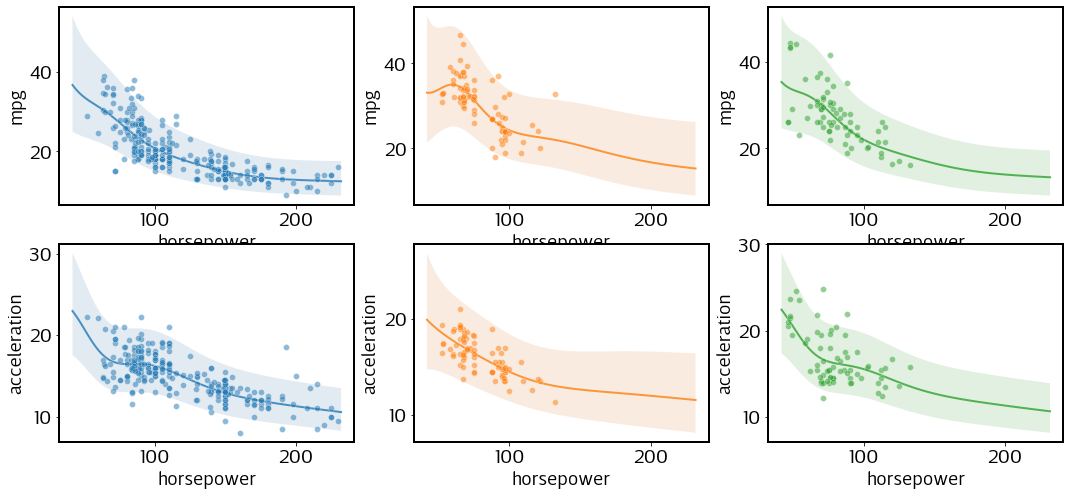

In [12]:
gp.fit(outputs=['mpg', 'acceleration'], categorical_dims=['origin'], continuous_dims=['horsepower'], linear_dims=['horsepower']);

X = gp.prepare_grid()
axs = plt.subplots(2,3, figsize=(18, 8))[1]
for i, (row, origin) in enumerate(zip(axs.T, cars.origin.unique())):
    Y = gp.predict_grid(categorical_levels={'origin': origin})
    for ax, output in zip(row, gp.outputs):
        y = Y.get(output)

        gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette(f'C{i}'))

        sns.scatterplot(data=cars[cars.origin==origin], x='horsepower', y=output, color=f'C{i}', alpha=0.5, ax=ax);

## Multi-dimensional regression

In [13]:
from matplotlib.colors import Normalize
norm = Normalize()
norm(ds.wide.mpg);

### 2D regression with and without linear kernel

Note that here we plot the coefficient of variation (with respect to aleatoric and epistemic uncertainty together) as dashed lines.

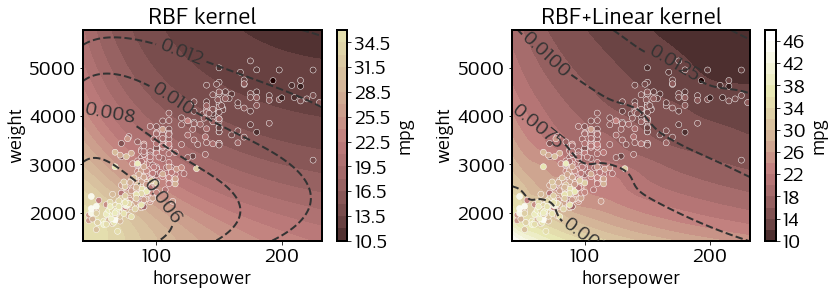

In [14]:
axs = plt.subplots(1,2, figsize=(12, 4.5))[1]
for ax, linear in zip(axs, [False, True]):
    linear_dims = ['horsepower','weight'] if linear else None
    
    gp.fit(outputs=['mpg'], continuous_dims=['horsepower','weight'], linear_dims=linear_dims);

    XY = gp.prepare_grid()
    X = XY['horsepower']
    Y = XY['weight']
    z = gp.predict_grid()

    plt.sca(ax)
    pp = gmb.ParrayPlotter(X, Y, z)
    pp(plt.contourf, levels=20, cmap='pink', norm=norm)
    pp.colorbar(ax=ax)

    cs = ax.contour(X.values(), Y.values(), z.σ/z.μ, levels=4, colors='0.2', linestyles='--')
    ax.clabel(cs)

    sns.scatterplot(data=cars, x='horsepower', y='weight', hue='mpg', palette='pink', norm=norm, ax=ax);
    ax.legend().remove()
    
    title = 'RBF+Linear kernel' if linear else 'RBF kernel'
    ax.set_title(title)
    
plt.tight_layout()

### 3D regression with 2D predictions

Note that here we plot the epistemic uncertainty as dashed lines.

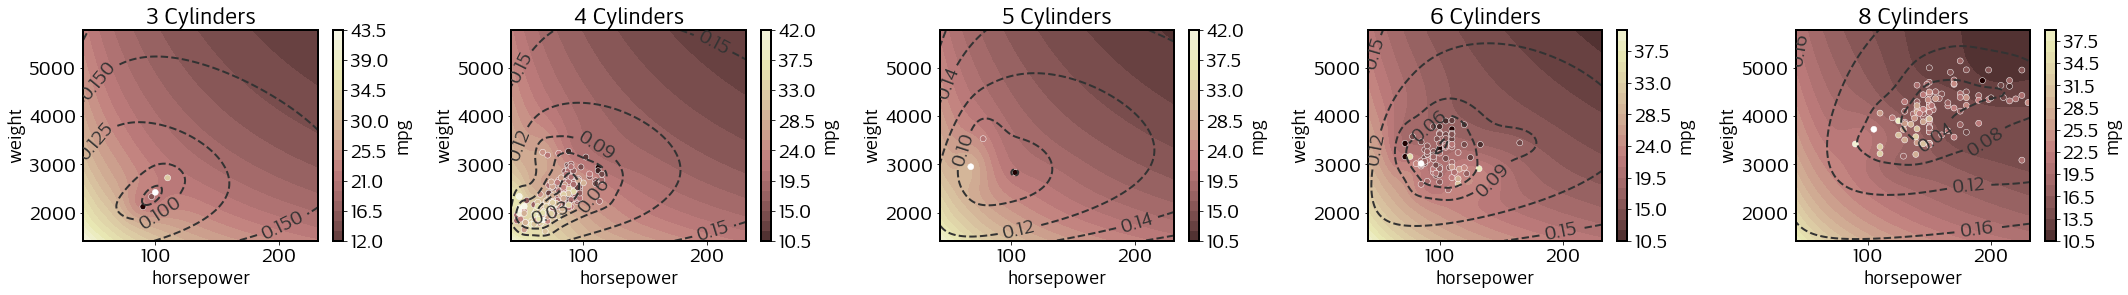

In [15]:
cylinders = cars.cylinders.unique()
cylinders.sort()

axs = plt.subplots(1, 5, figsize=(30, 4.5))[1]
    
gp.fit(outputs=['mpg'], continuous_dims=['horsepower','weight', 'cylinders'], linear_dims=['horsepower','weight', 'cylinders']);

for ax, cyl in zip(axs, cylinders):

    XY = gp.prepare_grid(at=gp.parray(cylinders=cyl))
    X = XY['horsepower']
    Y = XY['weight']
    z = gp.predict_grid(with_noise=False)

    plt.sca(ax)
    pp = gmb.ParrayPlotter(X, Y, z)
    pp(plt.contourf, levels=20, cmap='pink', norm=norm)
    pp.colorbar(ax=ax)

    cs = ax.contour(X.values(), Y.values(), z.σ, levels=4, colors='0.2', linestyles='--')
    ax.clabel(cs)

    sns.scatterplot(data=cars[cars.cylinders==cyl], x='horsepower', y='weight', hue='mpg', palette='pink', norm=norm, ax=ax);
    ax.legend().remove()
    
    title = 'RBF+Linear kernel' if linear else 'RBF kernel'
    ax.set_title(f'{cyl} Cylinders')
    
plt.tight_layout()